# Simplify network topology and consolidate intersections

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [1]:
import networkx as nx
import osmnx as ox

%matplotlib inline
ox.__version__

'1.6.0'

## 1. Complex intersection consolidation

Many real-world street networks feature complex intersections and traffic circles, resulting in a cluster of graph nodes where there is really just one true intersection, as we would think of it in transportation or urban design. Similarly, divided roads are often represented by separate centerline edges: the intersection of two divided roads thus creates 4 nodes, representing where each edge intersects a perpendicular edge, but these 4 nodes represent a single intersection in the real world. Traffic circles similarly create a cluster of nodes where each street's edge intersects the roundabout.

OSMnx can consolidate nearby intersections and optionally rebuild the graph's topology.

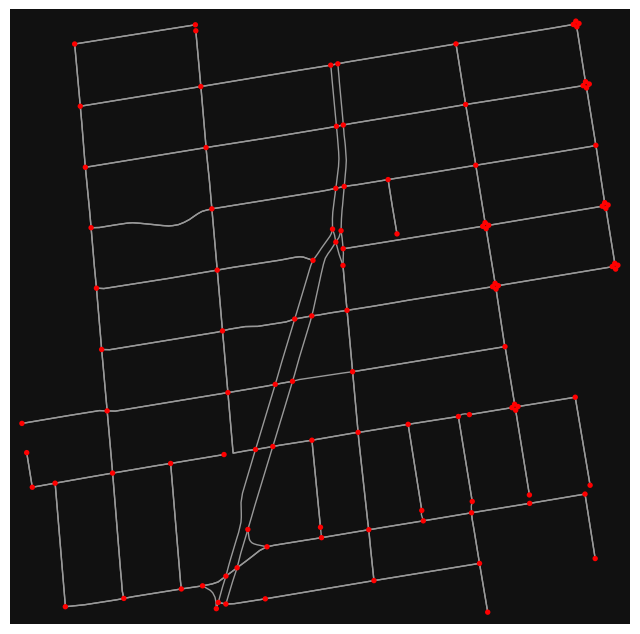

In [2]:
# get a street network and plot it with all edge intersections
point = 37.858495, -122.267468
G = ox.graph_from_point(point, network_type="drive", dist=500)
fig, ax = ox.plot_graph(G, node_color="r")

Notice the complex intersections and traffic circles creating clusters of nodes.

We'll specify that any nodes with 15 meter buffers of each other in this network are part of the same intersection. Adjust this tolerance based on the street design standards in the community you are examining, and use a projected graph to work in meaningful units like meters. We'll also specify that we do not want dead-ends returned in our list of consolidated intersections.

In [3]:
# get a GeoSeries of consolidated intersections
G_proj = ox.project_graph(G)
ints = ox.consolidate_intersections(G_proj, rebuild_graph=False, tolerance=15, dead_ends=False)
len(ints)

66

In [4]:
# compare to number of nodes in original graph
len(G)

110

Note that these cleaned up intersections give us more accurate intersection counts and densities, but do not alter or integrate with the network's topology.

To do that, we need to **rebuild the graph**.

In [5]:
# consolidate intersections and rebuild graph topology
# this reconnects edge geometries to the new consolidated nodes
G2 = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=15, dead_ends=False)
len(G2)

66

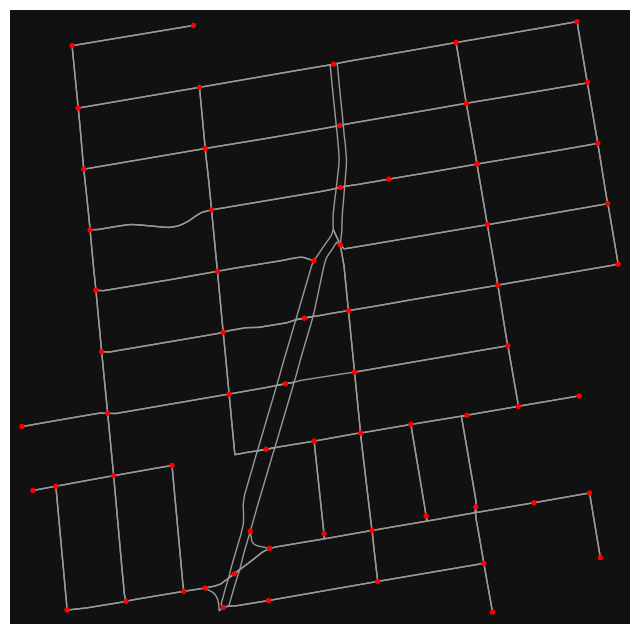

In [6]:
fig, ax = ox.plot_graph(G2, node_color="r")

Notice how the traffic circles' many nodes are merged into a new single centroid node, with edge geometries extended to connect to it. Similar consolidation occurs at the intersection of the divided roads.

Running `consolidate_intersections` with `rebuild_graph=True` may yield somewhat (but not very) different intersection counts/densities compared to `rebuild_graph=False`. The difference lies in that the latter just merges buffered node points that overlap, whereas the former checks the topology of the overlapping node buffers before merging them.

This prevents topologically remote but spatially proximate nodes from being merged. For example:

  - A street intersection may lie directly below a freeway overpass's intersection with an on-ramp. We would not want to merge these together and connnect their edges: they are distinct junctions in the system of roads.
  - In a residential neighborhood, a bollarded street may create a dead-end immediately next to an intersection or traffic circle. We would not want to merge this dead-end with the intersection and connect their edges.

These examples illustrate (two-dimensional) geometric proximity, but topological remoteness. Accordingly, in some situations we may expect higher intersection counts when using `rebuild_graph=True` because it is more cautious with merging in these cases. The trade-off is that it has higher time complexity than `rebuild_graph=False`.

## 2. Graph simplification

Use simplification to clean-up nodes that are not intersections or dead-ends while retaining the complete edge geometry. OSMnx does this automatically by default when constructing a graph.

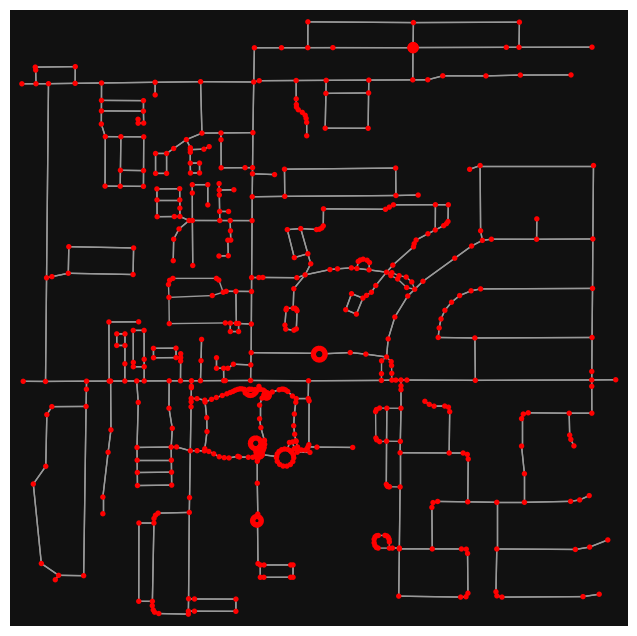

In [7]:
# create a network around some (lat, lng) point and plot it
location_point = (33.299896, -111.831638)
G = ox.graph_from_point(location_point, dist=500, simplify=False)
fig, ax = ox.plot_graph(G, node_color="r")

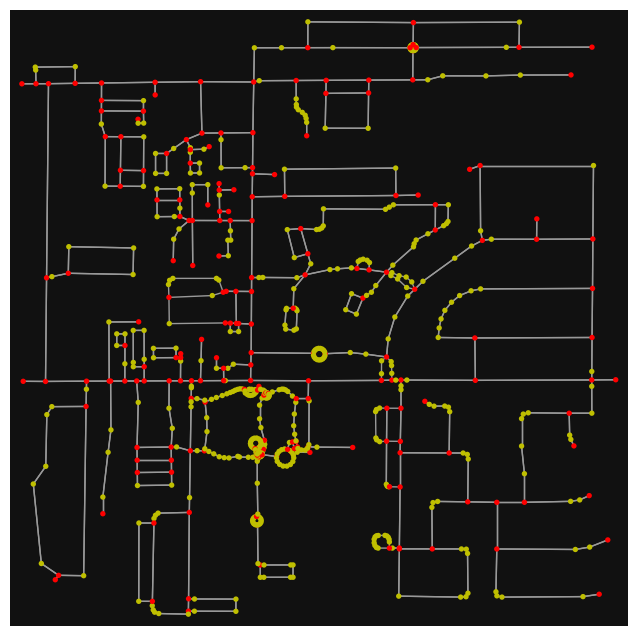

In [8]:
# show which nodes we'd remove if we simplify it (yellow)
nc = ["r" if ox.simplification._is_endpoint(G, node) else "y" for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)

In [9]:
# simplify the network
G2 = ox.simplify_graph(G)

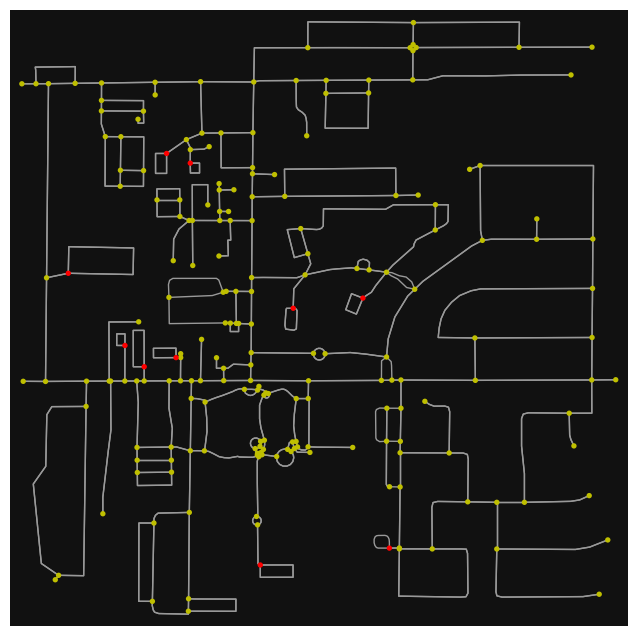

In [10]:
# plot the simplified network and highlight any self-loop edges
loops = [edge[0] for edge in nx.selfloop_edges(G2)]
nc = ["r" if node in loops else "y" for node in G2.nodes()]
fig, ax = ox.plot_graph(G2, node_color=nc)

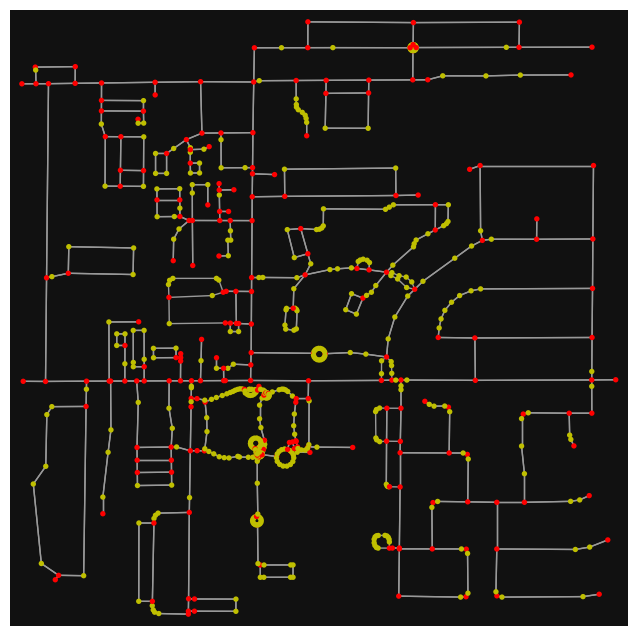

In [11]:
# turn off strict mode and see what nodes we'd remove
nc = ["r" if ox.simplification._is_endpoint(G, node, strict=False) else "y" for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)

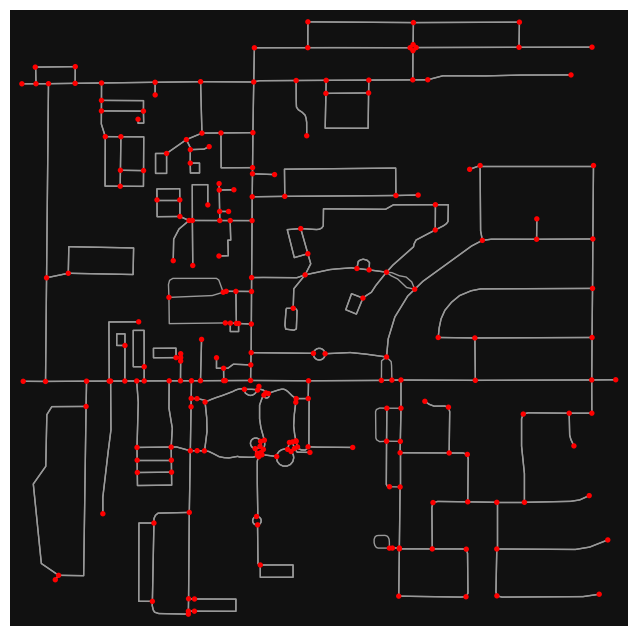

In [12]:
# simplify network with strict mode turned off
G3 = ox.simplify_graph(G.copy(), strict=False)
fig, ax = ox.plot_graph(G3, node_color="r")

## 3. Cleaning up the periphery of the network

This is related to simplification. OSMnx by default (with clean_periphery parameter equal to True) buffers the area you request by 0.5km, and then retrieves the street network within this larger, buffered area. Then it simplifies the topology so that nodes represent intersections of streets (rather than including all the interstitial OSM nodes). Then it calculates the (undirected) degree of each node in this larger network. Next it truncates this network by the actual area you requested (either by bounding box, or by polygon). Finally it saves a dictionary of node degree values as a graph attribute.

This has two primary benefits. First, it cleans up stray false edges around the periphery. If clean_periphery=False, peripheral non-intersection nodes within the requested area appear to be cul-de-sacs, as the rest of the edge leading to an intersection outside the area is ignored. If clean_periphery=True, the larger graph is first created, allowing simplification of such edges to their true intersections, allowing their entirety to be pruned after truncating down to the actual requested area. Second, it gives accurate node degrees by both a) counting node neighbors even if they fall outside the retained network (so you don't claim a degree-4 node is degree-2 because only 2 of its neighbors lie within the area), and b) not counting all those stray false edges' terminus nodes as cul-de-sacs that otherwise grossly inflate the count of nodes with degree=1, even though these nodes are really just interstitial nodes in the middle of a chopped-off street segment between intersections.

See two examples below.

In [13]:
# get some bbox
bbox = ox.utils_geo.bbox_from_point((45.518698, -122.679964), dist=300)
north, south, east, west = bbox

c:\Users\67483\.conda\envs\ox\Lib\site-packages\osmnx\graph.py:88: UserWarning: The clean_periphery argument has been deprecated and will be removed in a future release. Future behavior will be as though clean_periphery=True.
  G = graph_from_polygon(
c:\Users\67483\.conda\envs\ox\Lib\site-packages\osmnx\graph.py:88: UserWarning: the graph-level street_count attribute will likely be inaccurate when you set clean_periphery=False
  G = graph_from_polygon(


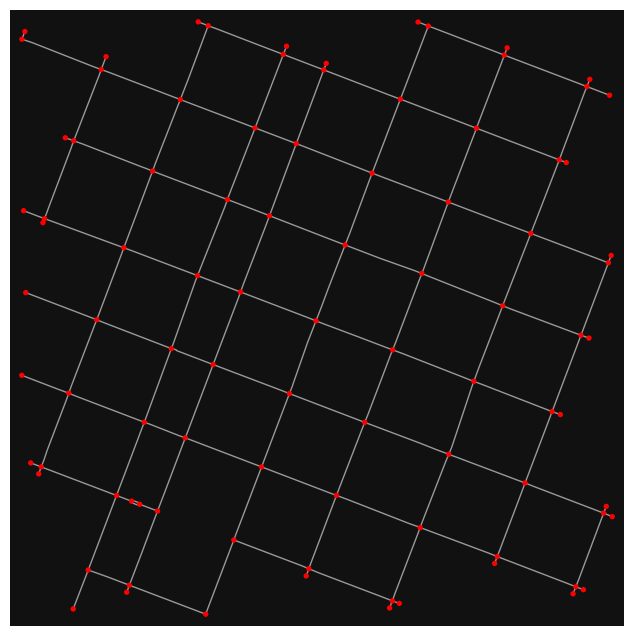

In [14]:
G = ox.graph_from_bbox(north, south, east, west, network_type="drive", clean_periphery=False)
fig, ax = ox.plot_graph(G, node_color="r")

In [15]:
# the node degree distribution for this graph has many false cul-de-sacs
k = dict(G.degree())
{n: list(k.values()).count(n) for n in range(max(k.values()) + 1)}

{0: 0, 1: 30, 2: 2, 3: 8, 4: 51}

Above, notice all the peripheral stray edge stubs. Below, notice these are cleaned up and that the node degrees are accurate with regards to the wider street network that may extend beyond the limits of the requested area.

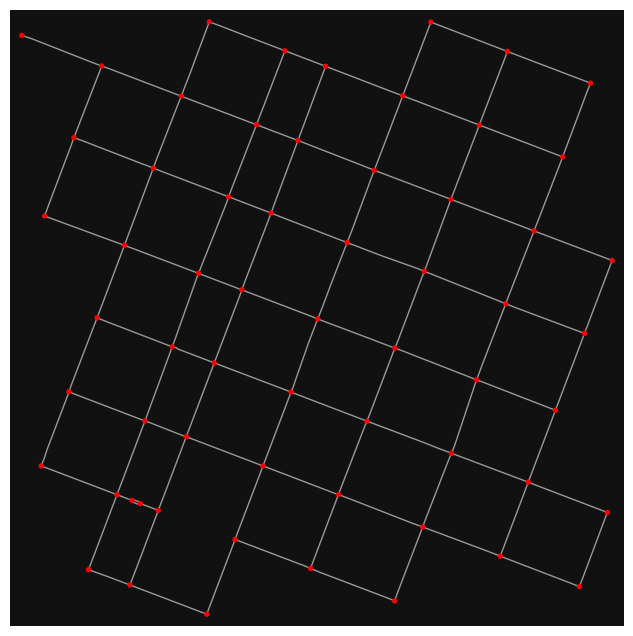

In [16]:
G = ox.graph_from_bbox(north, south, east, west, network_type="drive")
fig, ax = ox.plot_graph(G, node_color="r")

In [17]:
# the streets per node distribution for this cleaned up graph is more accurate
# dict keys = count of streets emanating from the node (ie, intersections and dead-ends)
# dict vals = number of nodes with that count
k = nx.get_node_attributes(G, "street_count")
{n: list(k.values()).count(n) for n in range(max(k.values()) + 1)}

{0: 0, 1: 0, 2: 0, 3: 5, 4: 56}

A final example. Compare the network below to the ones in the section above. It has the stray peripheral edges cleaned up. Also notice toward the bottom left, two interstitial nodes remain in that east-west street. Why? These are actually intersections, but their (southbound) edges were removed because these edges' next intersections were south of the requested area's boundaries. However, OSMnx correctly kept these nodes in the graph because they are in fact intersections and should be counted in measures of intersection density, etc.

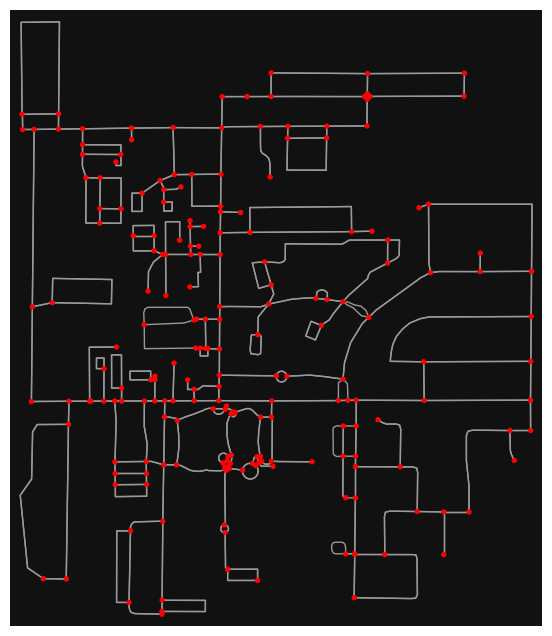

In [18]:
location_point = (33.299896, -111.831638)
G = ox.graph_from_point(location_point, dist=500, simplify=True)
fig, ax = ox.plot_graph(G, node_color="r")